In [ ]:
import pickle
import os
 
from keras.datasets import mnist, cifar100,cifar10
from keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array
 
import pandas as pd
 
import numpy as np
from os import walk, getcwd
import h5py
 
import scipy
from glob import glob
 
from keras.applications import vgg19
from keras import backend as K
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
import zipfile
import os
from google.colab import drive
drive.mount('/content/drive')
zip_file = '/content/drive/MyDrive/ОбучениеML/Практика/Датасеты/banana.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

Mounted at /content/drive


In [ ]:
data_dir = './banana.npy'

In [ ]:
data = np.load(data_dir)

In [ ]:
np.shape(data)

(307936, 784)

In [ ]:
np.amax(data)

255

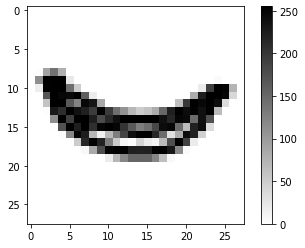

In [ ]:
image = data[0].reshape((28, 28))
 
# отрисовываем изображение
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

ValueError: ignored

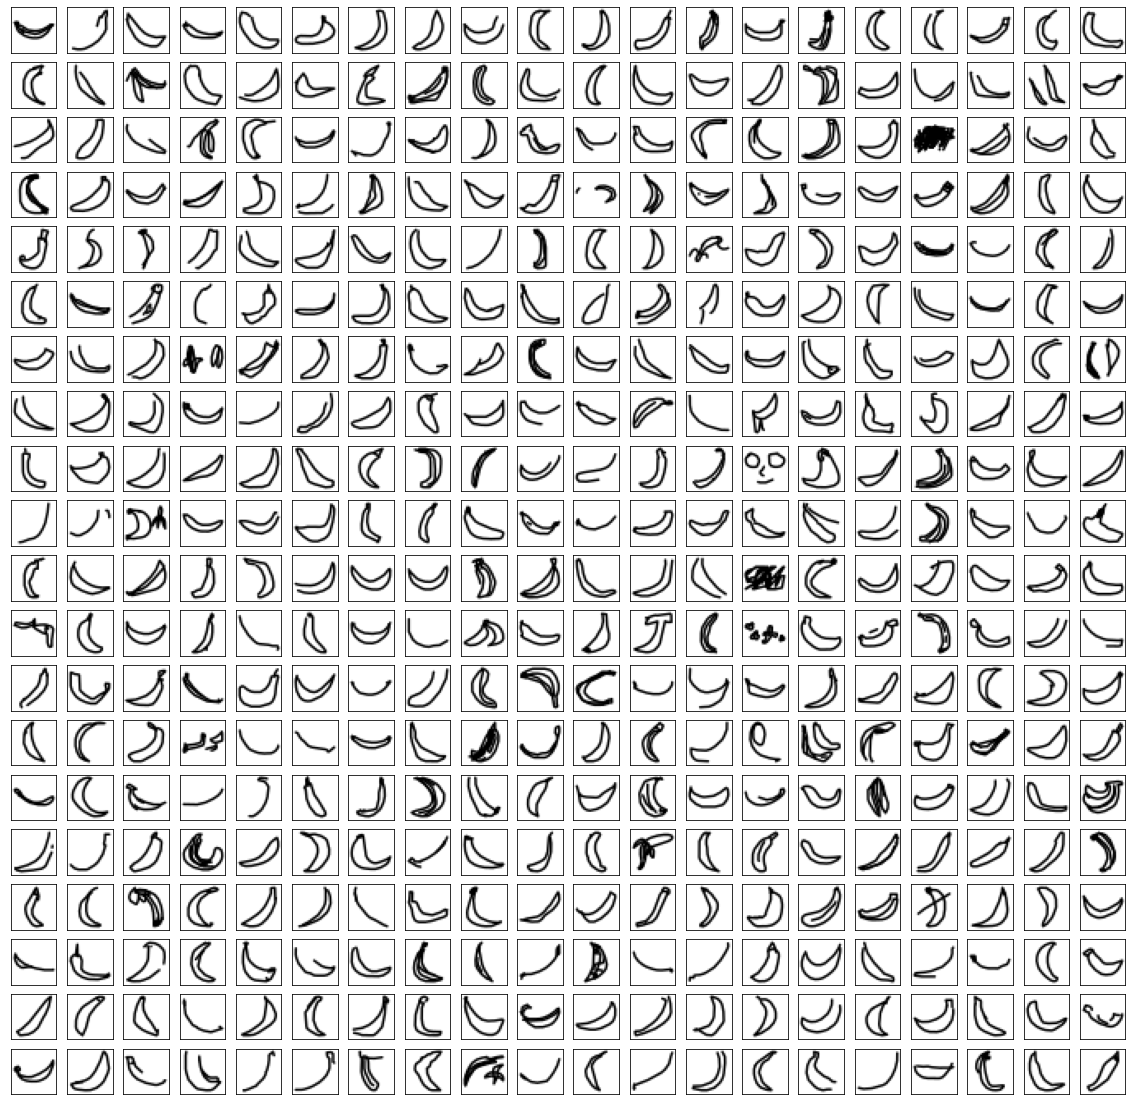

In [ ]:
plt.figure(figsize=(20,20))
n = 20
i = 0
for (image) in data:
  image = image.reshape((28,28))
  plt.subplot(n,n,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  i += 1
plt.show()

In [ ]:
def load_safari(data):
    slice_train = int(100000)  ###Setting value to be 80000 for the final dataset
    x = data
    #seed = np.random.randint(1, 10e6) 
    x = (x.astype('float32') - 127.5) / 127.5
    x = x.reshape(x.shape[0], 28, 28)
    #np.random.seed(seed)
    #np.random.shuffle(x)
    x = x[:slice_train]
    xtotal = x
    return xtotal

In [ ]:
train = load_safari(data)
train.shape

(100000, 28, 28)

ValueError: ignored

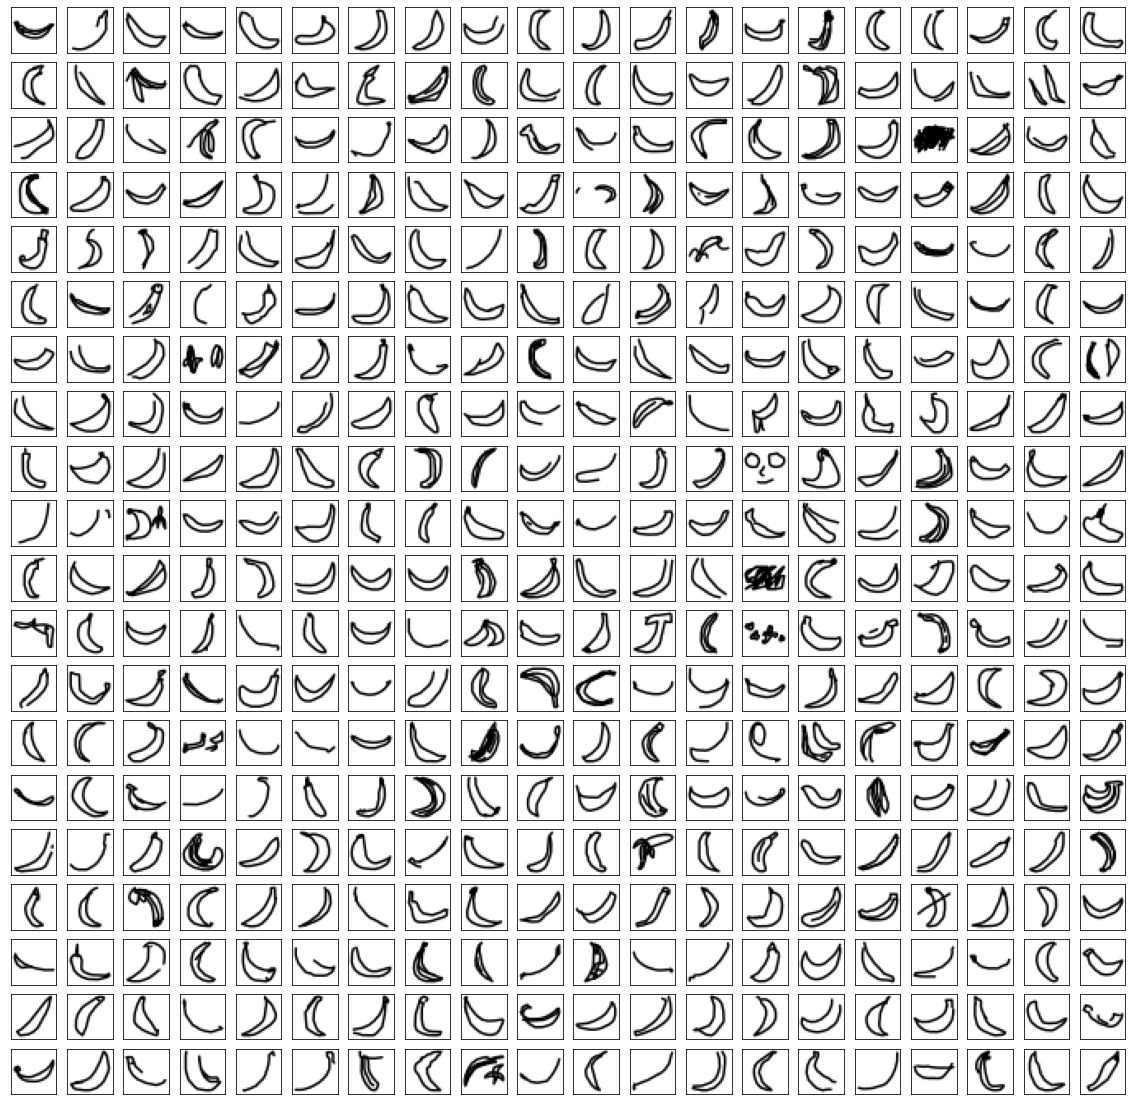

In [ ]:
plt.figure(figsize=(20,20))
n = 20
i = 0
for (image) in train:
  plt.subplot(n,n,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  i += 1
plt.show()

In [ ]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.merge import _Merge
 
from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomNormal
 
import numpy as np
import json
import os
import pickle as pkl
import matplotlib.pyplot as plt
 
 
class GAN():
    def __init__(self
        , input_dim
        , discriminator_conv_filters
        , discriminator_conv_kernel_size
        , discriminator_conv_strides
        , discriminator_batch_norm_momentum
        , discriminator_activation
        , discriminator_dropout_rate
        , discriminator_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , z_dim
        ):
 
        self.name = 'gan'
 
        self.input_dim = input_dim
        self.discriminator_conv_filters = discriminator_conv_filters
        self.discriminator_conv_kernel_size = discriminator_conv_kernel_size
        self.discriminator_conv_strides = discriminator_conv_strides
        self.discriminator_batch_norm_momentum = discriminator_batch_norm_momentum
        self.discriminator_activation = discriminator_activation
        self.discriminator_dropout_rate = discriminator_dropout_rate
        self.discriminator_learning_rate = discriminator_learning_rate
 
        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser
        self.z_dim = z_dim
 
        self.n_layers_discriminator = len(discriminator_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)
 
        self.weight_init = RandomNormal(mean=0., stddev=0.02)
 
        self.d_losses = []
        self.g_losses = []
 
        self.epoch = 0
 
        self._build_discriminator()
        self._build_generator()
 
        self._build_adversarial()
 
    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer
 
    def _build_discriminator(self):
 
        ### THE discriminator
        discriminator_input = Input(shape=self.input_dim, name='discriminator_input')
 
        x = discriminator_input
 
        for i in range(self.n_layers_discriminator):
 
            x = Conv2D(
                filters = self.discriminator_conv_filters[i]
                , kernel_size = self.discriminator_conv_kernel_size[i]
                , strides = self.discriminator_conv_strides[i]
                , padding = 'same'
                , name = 'discriminator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)
 
            if self.discriminator_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.discriminator_batch_norm_momentum)(x)
 
            x = self.get_activation(self.discriminator_activation)(x)
 
            if self.discriminator_dropout_rate:
                x = Dropout(rate = self.discriminator_dropout_rate)(x)
 
        x = Flatten()(x)
        
        discriminator_output = Dense(1, activation='sigmoid', kernel_initializer = self.weight_init)(x)
 
        self.discriminator = Model(discriminator_input, discriminator_output)
 
 
    def _build_generator(self):
 
        ### THE generator
Дз
        generator_input = Input(shape=(self.z_dim,), name='generator_input')
 
        x = generator_input
 
        x = Dense(np.prod(self.generator_initial_dense_layer_size), kernel_initializer = self.weight_init)(x)
 
        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)
 
        x = self.get_activation(self.generator_activation)(x)
 
        x = Reshape(self.generator_initial_dense_layer_size)(x)
 
        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)
 
        for i in range(self.n_layers_generator):
 
            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                )(x)
            else:
 
                x = Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)
 
            if i < self.n_layers_generator - 1:
 
                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)
 
                x = self.get_activation(self.generator_activation)(x)
                    
                
            else:
 
                x = Activation('tanh')(x)
 
 
        generator_output = x
 
        self.generator = Model(generator_input, generator_output)
 
       
    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = RMSprop(lr=lr)
        else:
            opti = Adam(lr=lr)
 
        return opti
 
    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val
 
 
    def _build_adversarial(self):
        
        ### COMPILE DISCRIMINATOR
 
        self.discriminator.compile(
        optimizer=self.get_opti(self.discriminator_learning_rate)  
        , loss = 'binary_crossentropy'
        ,  metrics = ['accuracy']
        )
        
        ### COMPILE THE FULL GAN
 
        self.set_trainable(self.discriminator, False)
 
        model_input = Input(shape=(self.z_dim,), name='model_input')
        model_output = self.discriminator(self.generator(model_input))
        self.model = Model(model_input, model_output)
 
        self.model.compile(optimizer=self.get_opti(self.generator_learning_rate) , loss='binary_crossentropy', metrics=['accuracy'])
 
        self.set_trainable(self.discriminator, True)
 
 
 
  
    def train_discriminator(self, x_train, batch_size, using_generator):
 
        valid = np.ones((batch_size,1))
        fake = np.zeros((batch_size,1))
 
        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        gen_imgs = self.generator.predict(noise)
 
        d_loss_real, d_acc_real =   self.discriminator.train_on_batch(true_imgs, valid)
        d_loss_fake, d_acc_fake =   self.discriminator.train_on_batch(gen_imgs, fake)
        d_loss =  0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)
 
        return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]
 
    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)
 
 
    def train(self, x_train, batch_size, epochs, run_folder = 0
    , print_every_n_batches = 50
    , using_generator = False):
Эххх
        for epoch in range(self.epoch, self.epoch + epochs):
 
            d = self.train_discriminator(x_train, batch_size, using_generator)
            g = self.train_generator(batch_size)
 
            print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))
 
            self.d_losses.append(d)
            self.g_losses.append(g)
 
            
 
            self.epoch += 1
 
    
    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)
 
        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)
 
        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0
 
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()
 
 
 
 
    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.discriminator, to_file=os.path.join(run_folder ,'viz/discriminator.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)
 
 
 
    def save(self, folder):
 
        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pkl.dump([
                self.input_dim
                , self.discriminator_conv_filters
                , self.discriminator_conv_kernel_size
                , self.discriminator_conv_strides
                , self.discriminator_batch_norm_momentum
                , self.discriminator_activation
                , self.discriminator_dropout_rate
                , self.discriminator_learning_rate
                , self.generator_initial_dense_layer_size
                , self.generator_upsample
                , self.generator_conv_filters
                , self.generator_conv_kernel_size
                , self.generator_conv_strides
                , self.generator_batch_norm_momentum
                , self.generator_activation
                , self.generator_dropout_rate
                , self.generator_learning_rate
                , self.optimiser
                , self.z_dim
                ], f)
 
        self.plot_model(folder)
 
    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.discriminator.save(os.path.join(run_folder, 'discriminator.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))
        pkl.dump(self, open( os.path.join(run_folder, "obj.pkl"), "wb" ))
 
    def load_weights(self, filepath):
        self.model.load_weights(filepath)

IndentationError: ignored

In [ ]:
class WGAN():
    def __init__(self
        , input_dim
        , critic_conv_filters
        , critic_conv_kernel_size
        , critic_conv_strides
        , critic_batch_norm_momentum
        , critic_activation
        , critic_dropout_rate
        , critic_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , z_dim
        ):

        self.name = 'gan'

        self.input_dim = input_dim
        self.critic_conv_filters = critic_conv_filters
        self.critic_conv_kernel_size = critic_conv_kernel_size
        self.critic_conv_strides = critic_conv_strides
        self.critic_batch_norm_momentum = critic_batch_norm_momentum
        self.critic_activation = critic_activation
        self.critic_dropout_rate = critic_dropout_rate
        self.critic_learning_rate = critic_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser

        self.z_dim = z_dim

        

        self.n_layers_critic = len(critic_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = RandomNormal(mean=0., stddev=0.02)

        self.d_losses = []
        self.g_losses = []

        self.epoch = 0

    
        self._build_critic()
        self._build_generator()

        self._build_adversarial()

    def wasserstein(self, y_true, y_pred):
        return - K.mean(y_true * y_pred)

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer

    def _build_critic(self):

        ### THE critic
        critic_input = Input(shape=self.input_dim, name='critic_input')

        x = critic_input

        for i in range(self.n_layers_critic):

            x = Conv2D(
                filters = self.critic_conv_filters[i]
                , kernel_size = self.critic_conv_kernel_size[i]
                , strides = self.critic_conv_strides[i]
                , padding = 'same'
                , name = 'critic_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.critic_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.critic_batch_norm_momentum)(x)

            x = self.get_activation(self.critic_activation)(x)

            if self.critic_dropout_rate:
                x = Dropout(rate = self.critic_dropout_rate)(x)

        x = Flatten()(x)

        # x = Dense(512, kernel_initializer = self.weight_init)(x)

        # x = self.get_activation(self.critic_activation)(x)
        
        critic_output = Dense(1, activation=None
        , kernel_initializer = self.weight_init
        )(x)

        self.critic = Model(critic_input, critic_output)



    def _build_generator(self):

        ### THE generator

        generator_input = Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size)
        ,kernel_initializer = self.weight_init
        )(x)

        
        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

        x = self.get_activation(self.generator_activation)(x)

        x = Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                filters = self.generator_conv_filters[i]
                , kernel_size = self.generator_conv_kernel_size[i]
                , padding = 'same'
                , name = 'generator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)
            else:

                x = Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)
            
            else:
                x = Activation('tanh')(x)


        generator_output = x

        self.generator = Model(generator_input, generator_output)


    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = RMSprop(lr=lr)
        else:
            opti = Adam(lr=lr)

        return opti

    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val


    def _build_adversarial(self):
        
        ### COMPILE critic

        self.critic.compile(
            optimizer=self.get_opti(self.critic_learning_rate) 
            , loss = self.wasserstein
        )
        
        ### COMPILE THE FULL GAN

        self.set_trainable(self.critic, False)

        model_input = Input(shape=(self.z_dim,), name='model_input')
        model_output = self.critic(self.generator(model_input))
        self.model = Model(model_input, model_output)
        
        self.model.compile(
            optimizer=self.get_opti(self.generator_learning_rate)
            , loss=self.wasserstein
            )

        self.set_trainable(self.critic, True)



    
    def train_critic(self, x_train, batch_size, clip_threshold, using_generator):

        valid = np.ones((batch_size,1))
        fake = -np.ones((batch_size,1))

        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
        
        
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        d_loss_real =   self.critic.train_on_batch(true_imgs, valid)
        d_loss_fake =   self.critic.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        for l in self.critic.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -clip_threshold, clip_threshold) for w in weights]
            l.set_weights(weights)

        # for l in self.critic.layers:
        
        #     weights = l.get_weights()
        #     if 'batch_normalization' in l.get_config()['name']:
        #         pass
        #         # weights = [np.clip(w, -0.01, 0.01) for w in weights[:2]] + weights[2:]
        #     else:
        #         weights = [np.clip(w, -0.01, 0.01) for w in weights]
            
        #     l.set_weights(weights)

        return [d_loss, d_loss_real, d_loss_fake]

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)


    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 10
        , n_critic = 5
        , clip_threshold = 0.01
        , using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            for _ in range(n_critic):
                d_loss = self.train_critic(x_train, batch_size, clip_threshold, using_generator)

            g_loss = self.train_generator(batch_size)
               
            # Plot the progress
            print ("%d [D loss: (%.3f)(R %.3f, F %.3f)]  [G loss: %.3f] " % (epoch, d_loss[0], d_loss[1], d_loss[2], g_loss))
            
            self.d_losses.append(d_loss)
            self.g_losses.append(g_loss)

            # If at save interval => save generated image samples
            if epoch % print_every_n_batches == 0:
                self.sample_images(run_folder)
                self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                self.save_model(run_folder)
            
            self.epoch+=1

    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        #Rescale images 0 - 1

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.critic, to_file=os.path.join(run_folder ,'viz/critic.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)



            
    def save(self, folder):

            with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
                pickle.dump([
                    self.input_dim
                    , self.critic_conv_filters
                    , self.critic_conv_kernel_size
                    , self.critic_conv_strides
                    , self.critic_batch_norm_momentum
                    , self.critic_activation
                    , self.critic_dropout_rate
                    , self.critic_learning_rate
                    , self.generator_initial_dense_layer_size
                    , self.generator_upsample
                    , self.generator_conv_filters
                    , self.generator_conv_kernel_size
                    , self.generator_conv_strides
                    , self.generator_batch_norm_momentum
                    , self.generator_activation
                    , self.generator_dropout_rate
                    , self.generator_learning_rate
                    , self.optimiser
                    , self.z_dim
                    ], f)

            self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.critic.save(os.path.join(run_folder, 'critic.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))
        pickle.dump(self, open( os.path.join(run_folder, "obj.pkl"), "wb" ))

    def load_weights(self, filepath):
        self.model.load_weights(filepath)


In [ ]:
BATCH_SIZE = 64
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 5

In [ ]:
gan.train(     
    train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)

Выходные данные были обрезаны до нескольких последних строк (5000).
1000 [D loss: (0.234)(R 0.230, F 0.239)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.540] [G acc: 0.000]
1001 [D loss: (0.523)(R 0.478, F 0.569)] [D acc: (0.820)(0.781, 0.859)] [G loss: 2.285] [G acc: 0.016]
1002 [D loss: (0.362)(R 0.457, F 0.267)] [D acc: (0.820)(0.750, 0.891)] [G loss: 2.232] [G acc: 0.016]
1003 [D loss: (0.295)(R 0.365, F 0.225)] [D acc: (0.883)(0.797, 0.969)] [G loss: 2.221] [G acc: 0.016]
1004 [D loss: (0.186)(R 0.194, F 0.178)] [D acc: (0.930)(0.891, 0.969)] [G loss: 2.377] [G acc: 0.016]
1005 [D loss: (0.336)(R 0.333, F 0.339)] [D acc: (0.891)(0.859, 0.922)] [G loss: 2.308] [G acc: 0.016]
1006 [D loss: (0.416)(R 0.516, F 0.316)] [D acc: (0.820)(0.734, 0.906)] [G loss: 2.141] [G acc: 0.000]
1007 [D loss: (0.350)(R 0.413, F 0.287)] [D acc: (0.867)(0.797, 0.938)] [G loss: 2.118] [G acc: 0.031]
1008 [D loss: (0.309)(R 0.394, F 0.224)] [D acc: (0.859)(0.750, 0.969)] [G loss: 2.199] [G acc: 0.031]
1009 

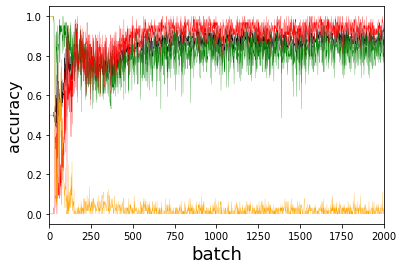

In [ ]:
fig = plt.figure()
plt.plot([x[3] for x in gan.d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in gan.g_losses], color='orange', linewidth=0.25)
 
plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)
 
plt.xlim(0, 2000)
 
plt.show()

In [ ]:
# run params
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'camel'
RUN_FOLDER = './'
 
 
if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))
 
mode =  'build' #'load' #

FileNotFoundError: ignored

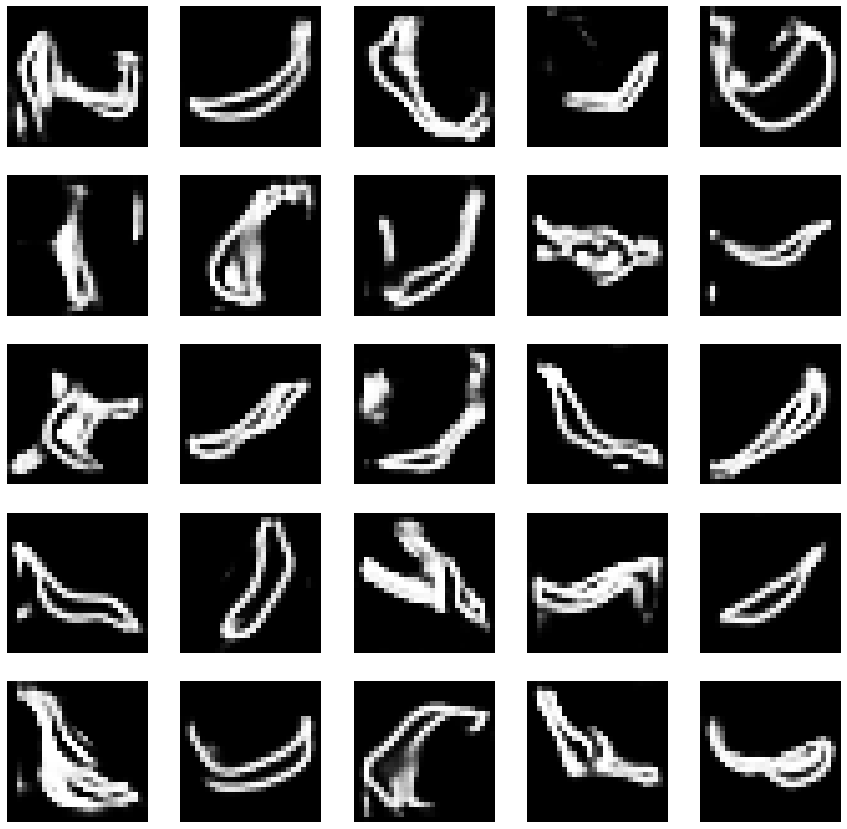

In [ ]:
gan.sample_images(RUN_FOLDER)